# Packages

In [1]:
import pandas as pd
import os
import shap
shap.initjs()
from sklearn import metrics
from pandas import read_csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
import joblib
from xgboost import XGBRegressor
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_no_fac = pd.read_csv('dataFullNoFacilities.csv', index_col=0)
data_facilities = pd.read_csv('dataFacilities.csv', index_col=0)

# Functions

In [3]:
def percent_missing(df):
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
    
    return missing_value_df

# Without Facilities

## Handle Missing Values

In [4]:
houses_nofac = data_no_fac[data_no_fac['Product Type'] == 'house']
apartments_nofac = data_no_fac[data_no_fac['Product Type'] == 'apartment']

In [5]:
missing_apartments = percent_missing(apartments_nofac)
missing_houses = percent_missing(houses_nofac)

In [6]:
apartments_nofac.drop(columns=['Total Area', 'Floor Count'], inplace=True)
houses_nofac.drop(columns=['Apartment Floor'], inplace=True)

In [7]:
houses_nofac.fillna(houses_nofac['Floor Count'].median(), inplace = True)

## Subset 

In [8]:
feature_titles_houses = ['Room Count','Interior Area', 'Total Area', 'Bathroom Count', 'Floor Count',
                         'Latitude', 'Longitude', 'Material_Monolit', 'Material_Panel', 'Material_Stone',
                         'Material_bricks', 'Material_cassette', 'Material_other', 'Material_wooden']

feature_titles_apartments = ['Room Count','Interior Area', 'Apartment Floor', 'Bathroom Count',
                  'Latitude', 'Longitude', 'Material_Monolit', 'Material_Panel', 'Material_Stone',
                         'Material_bricks', 'Material_cassette', 'Material_other', 'Material_wooden']

target_title = ['Price']

In [9]:
X_houses_nofac = houses_nofac[feature_titles_houses]
X_apartments_nofac = apartments_nofac[feature_titles_apartments]

y_houses_nofac = houses_nofac[target_title]
y_apartments_nofac = apartments_nofac[target_title]

### Train/Test Split

In [10]:
X_houses_train_nofac, X_houses_test_nofac, y_houses_train_nofac, y_houses_test_nofac = train_test_split(X_houses_nofac, y_houses_nofac,
                                                                                test_size=0.2,
                                                                                random_state=22)

In [11]:
X_apartments_train_nofac, X_apartments_test_nofac, y_apartments_train_nofac, y_apartments_test_nofac = train_test_split(X_apartments_nofac, y_apartments_nofac,
                                                                                test_size=0.2,
                                                                                random_state=22)

# Without Facilities

## Handle Missing Values

In [12]:
houses = data_facilities[data_facilities['Product Type'] == 'house']
apartments = data_facilities[data_facilities['Product Type'] == 'apartment']

In [13]:
missing_apartments = percent_missing(apartments)
missing_houses = percent_missing(houses)

In [14]:
apartments.drop(columns=['Total Area', 'Floor Count', 'Sewerage', 'Constant Water'], inplace=True)
houses.drop(columns=['Apartment Floor', 'Sewerage', 'Constant Water'], inplace=True)

In [15]:
houses.fillna(houses['Floor Count'].median(), inplace = True)
houses.fillna(houses['Electricity'].median(), inplace = True)
houses.fillna(houses['Water'].median(), inplace = True)
houses.fillna(houses['Gas Available'].median(), inplace = True)
houses.fillna(houses['Heating'].median(), inplace = True)
houses.fillna(houses['Hot water'].median(), inplace = True)
houses.fillna(houses['Internet Available'].median(), inplace = True)
houses.fillna(houses['Air-conditioner'].median(), inplace = True)

In [16]:
apartments.fillna(apartments['Electricity'].median(), inplace = True)
apartments.fillna(apartments['Water'].median(), inplace = True)
apartments.fillna(apartments['Gas Available'].median(), inplace = True)
apartments.fillna(apartments['Heating'].median(), inplace = True)
apartments.fillna(apartments['Hot water'].median(), inplace = True)
apartments.fillna(apartments['Internet Available'].median(), inplace = True)
apartments.fillna(apartments['Air-conditioner'].median(), inplace = True)

## Subset

In [17]:
feature_titles_houses_fac = ['Room Count','Interior Area', 'Total Area', 'Floor Count', 'Bathroom Count',
                             'Latitude', 'Longitude', 'Material_Monolit', 'Material_Panel', 'Material_Stone',
                             'Material_other', 'Electricity', 'Water', 'Gas Available', 'Heating', 'Hot water',
                             'Internet Available', 'Air-conditioner']

feature_titles_apartments_fac = ['Room Count','Interior Area', 'Apartment Floor', 'Bathroom Count',
                                 'Latitude', 'Longitude', 'Material_Monolit', 'Material_Panel', 'Material_Stone',
                                 'Material_other', 'Electricity', 'Water', 'Gas Available', 'Heating', 'Hot water',
                                 'Internet Available', 'Air-conditioner']

target_title_fac = ['Price']

In [18]:
X_houses = houses[feature_titles_houses_fac]
X_apartments = apartments[feature_titles_apartments_fac]

y_houses = houses[target_title_fac]
y_apartments = apartments[target_title_fac]

### Train/Test Split

In [19]:
X_houses_train, X_houses_test, y_houses_train, y_houses_test = train_test_split(X_houses, y_houses,
                                                                                test_size=0.2,
                                                                                random_state=22)

In [20]:
X_apartments_train, X_apartments_test, y_apartments_train, y_apartments_test = train_test_split(X_apartments, y_apartments,
                                                                                test_size=0.2,
                                                                                random_state=22)

# Modeling

## Feature Importance

### With Facilities

#### Houses

In [21]:
model_houses = XGBRegressor(n_estimators=1000, max_depth=10, learning_rate=0.001,
                            verbosity = 0)

model_houses.fit(X_houses, y_houses)

explainer = shap.TreeExplainer(model_houses)
shap_values = explainer.shap_values(X_houses)

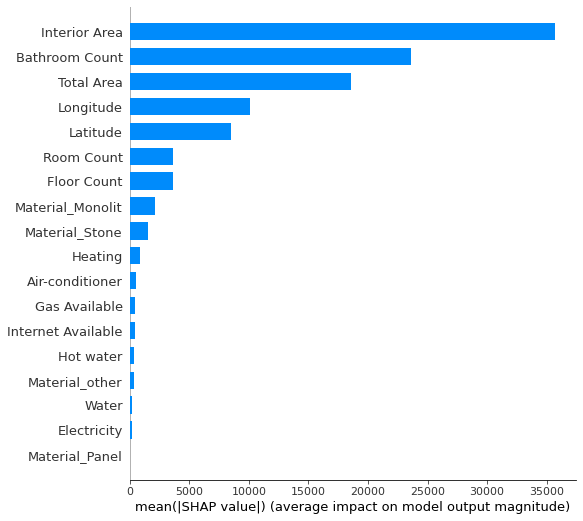

In [22]:
shap.summary_plot(shap_values, features=X_houses, feature_names=X_houses.columns, plot_type='bar')

#### Apartments

In [23]:
model_apartments = XGBRegressor(n_estimators=1000, max_depth=10, learning_rate=0.001,
                            verbosity = 0)

model_apartments.fit(X_apartments, y_apartments)

explainer = shap.TreeExplainer(model_apartments)
shap_values = explainer.shap_values(X_apartments)

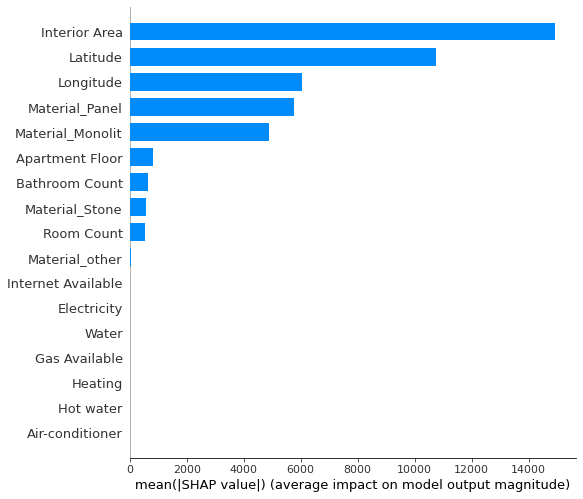

In [24]:
shap.summary_plot(shap_values, features=X_apartments, feature_names=X_apartments.columns, plot_type='bar')

### Without Facilities

#### Houses

In [25]:
model_houses = XGBRegressor(n_estimators=1000, max_depth=10, learning_rate=0.001,
                            verbosity = 0)

model_houses.fit(X_houses_nofac, y_houses_nofac)

explainer = shap.TreeExplainer(model_houses)
shap_values = explainer.shap_values(X_houses_nofac)

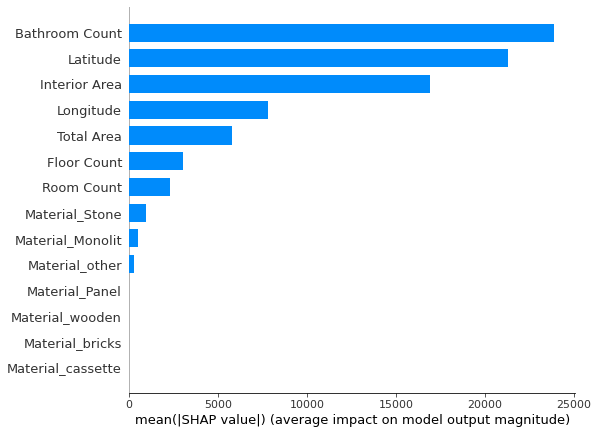

In [26]:
shap.summary_plot(shap_values, features=X_houses_nofac, feature_names=X_houses_nofac.columns, plot_type='bar')

In [27]:
new_feature_titles_houses = ['Room Count','Interior Area', 'Total Area', 'Bathroom Count', 'Floor Count',
                             'Latitude', 'Longitude', 'Material_Monolit', 'Material_Stone', 'Material_other']

In [28]:
X_houses_nofac_new = houses_nofac[new_feature_titles_houses]
y_houses_nofac_new = houses_nofac[target_title]

In [29]:
X_houses_train_nofac_new, X_houses_test_nofac_new, y_houses_train_nofac_new, y_houses_test_nofac_new = train_test_split(X_houses_nofac_new, y_houses_nofac_new,
                                                                                test_size=0.2,
                                                                                random_state=22)

#### Apartments

In [30]:
model_apartments = XGBRegressor(n_estimators=1000, max_depth=10, learning_rate=0.001,
                            verbosity = 0)

model_apartments.fit(X_apartments_nofac, y_apartments_nofac)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.001, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [31]:
explainer = shap.TreeExplainer(model_apartments)
shap_values = explainer.shap_values(X_apartments_nofac)

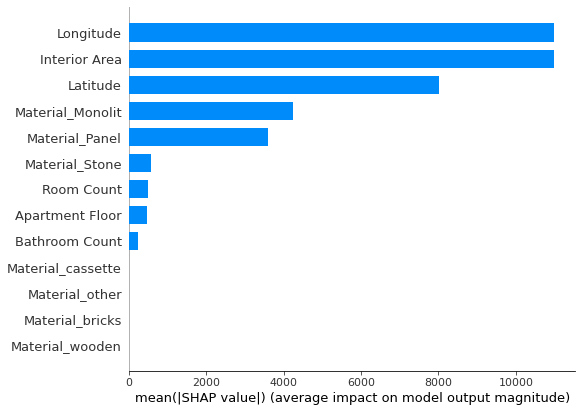

In [32]:
shap.summary_plot(shap_values, features=X_apartments_nofac, feature_names=X_apartments_nofac.columns, plot_type='bar')

In [33]:
new_feature_titles_apartments = ['Room Count','Interior Area', 'Apartment Floor', 'Bathroom Count',
                  'Latitude', 'Longitude', 'Material_Monolit', 'Material_Panel', 'Material_Stone']

In [34]:
X_apartments_nofac_new = apartments_nofac[new_feature_titles_apartments]
y_apartments_nofac_new = apartments_nofac[target_title]

In [35]:
X_apartments_train_nofac_new, X_apartments_test_nofac_new, y_apartments_train_nofac_new, y_apartments_test_nofac_new = train_test_split(X_apartments_nofac_new, y_apartments_nofac_new,
                                                                                test_size=0.2,
                                                                                random_state=22)

## XGBoost

In [36]:
params = { 'max_depth': [3,6,10],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [100, 500, 1000],
           'colsample_bytree': [0.3, 0.7]}

xgbr = xgb.XGBRegressor(seed = 22)

clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   cv = 10,
                   scoring = 'neg_mean_squared_error', 
                   verbose = 1,
                   n_jobs = -1)

### With Facilities 

#### Houses

In [37]:
clf.fit(X_houses_train, y_houses_train)
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Fitting 10 folds for each of 54 candidates, totalling 540 fits
Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 1000}
Lowest RMSE:  94438.95546848874


In [38]:
best_houses_fac = xgb.XGBRegressor(colsample_bytree = clf.best_params_['colsample_bytree'],
                                   learning_rate = clf.best_params_['learning_rate'], 
                                   max_depth = clf.best_params_['max_depth'],
                                   n_estimators = clf.best_params_['n_estimators'], seed = 22)

best_houses_fac.fit(X_houses_train, y_houses_train)

y_pred_best_houses_fac = best_houses_fac.predict(X_houses_test)
mse_xgb = mean_absolute_error(y_houses_test, y_pred_best_houses_fac)
mape_xgb = mean_absolute_percentage_error(y_houses_test, y_pred_best_houses_fac)


print("MAE: ", mse_xgb)
print("MAPE: ", mape_xgb)
print("R2: ", r2_score(y_houses_test, y_pred_best_houses_fac))

MAE:  59730.17044558359
MAPE:  0.26541817745436974
R2:  0.6407259024147467


#### Apartments

In [39]:
clf.fit(X_apartments_train, y_apartments_train)
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Fitting 10 folds for each of 54 candidates, totalling 540 fits
Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 500}
Lowest RMSE:  27697.621614534823


In [40]:
best_apartments_fac = xgb.XGBRegressor(colsample_bytree = clf.best_params_['colsample_bytree'],
                                   learning_rate = clf.best_params_['learning_rate'], 
                                   max_depth = clf.best_params_['max_depth'],
                                   n_estimators = clf.best_params_['n_estimators'], seed = 22)

best_apartments_fac.fit(X_apartments_train, y_apartments_train)

y_pred_best_apartments_fac = best_apartments_fac.predict(X_apartments_test)
mse_xgb = mean_absolute_error(y_apartments_test, y_pred_best_apartments_fac)
mape_xgb = mean_absolute_percentage_error(y_apartments_test, y_pred_best_apartments_fac)


print("MAE: ", mse_xgb)
print("MAPE: ", mape_xgb)
print("R2: ", r2_score(y_apartments_test, y_pred_best_apartments_fac))

MAE:  17177.76953323186
MAPE:  0.14956414964077264
R2:  0.7905424312313958


### Without Facilities

#### Houses

In [41]:
clf.fit(X_houses_train_nofac, y_houses_train_nofac)
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Fitting 10 folds for each of 54 candidates, totalling 540 fits
Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 500}
Lowest RMSE:  65727.57752610974


In [42]:
best_houses_nofac = xgb.XGBRegressor(colsample_bytree = clf.best_params_['colsample_bytree'],
                                   learning_rate = clf.best_params_['learning_rate'], 
                                   max_depth = clf.best_params_['max_depth'],
                                   n_estimators = clf.best_params_['n_estimators'], seed = 22)

best_houses_nofac.fit(X_houses_train_nofac, y_houses_train_nofac)

y_pred_best_houses_nofac = best_houses_nofac.predict(X_houses_test_nofac)
mse_xgb = mean_absolute_error(y_houses_test_nofac, y_pred_best_houses_nofac)
mape_xgb = mean_absolute_percentage_error(y_houses_test_nofac, y_pred_best_houses_nofac)


print("MAE: ", mse_xgb)
print("MAPE: ", mape_xgb)
print("R2: ", r2_score(y_houses_test_nofac, y_pred_best_houses_nofac))

MAE:  43173.47583566852
MAPE:  2.1375678707813868
R2:  0.6997351207479598


##### Heeding Feature Importance

In [43]:
clf.fit(X_houses_train_nofac_new, y_houses_train_nofac_new)
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Fitting 10 folds for each of 54 candidates, totalling 540 fits
Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 500}
Lowest RMSE:  65990.11324669691


In [44]:
best_houses_nofac_new = xgb.XGBRegressor(colsample_bytree = clf.best_params_['colsample_bytree'],
                                   learning_rate = clf.best_params_['learning_rate'], 
                                   max_depth = clf.best_params_['max_depth'],
                                   n_estimators = clf.best_params_['n_estimators'], seed = 22)

best_houses_nofac_new.fit(X_houses_train_nofac_new, y_houses_train_nofac_new)

y_pred_best_houses_nofac_new = best_houses_nofac_new.predict(X_houses_test_nofac_new)
mse_xgb = mean_absolute_error(y_houses_test_nofac_new, y_pred_best_houses_nofac_new)
mape_xgb = mean_absolute_percentage_error(y_houses_test_nofac_new, y_pred_best_houses_nofac_new)


print("MAE: ", mse_xgb)
print("MAPE: ", mape_xgb)
print("R2: ", r2_score(y_houses_test_nofac_new, y_pred_best_houses_nofac_new))

MAE:  43209.0928295012
MAPE:  2.114858821335058
R2:  0.6968167742783218


#### Apartments

In [45]:
clf.fit(X_apartments_train_nofac, y_apartments_train_nofac)
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Fitting 10 folds for each of 54 candidates, totalling 540 fits
Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 1000}
Lowest RMSE:  20443.979361543996


In [46]:
best_apartments_nofac = xgb.XGBRegressor(colsample_bytree = clf.best_params_['colsample_bytree'],
                                   learning_rate = clf.best_params_['learning_rate'], 
                                   max_depth = clf.best_params_['max_depth'],
                                   n_estimators = clf.best_params_['n_estimators'], seed = 22)

best_apartments_nofac.fit(X_apartments_train_nofac, y_apartments_train_nofac)

y_pred_best_apartments_nofac = best_apartments_nofac.predict(X_apartments_test_nofac)
mse_xgb = mean_absolute_error(y_apartments_test_nofac, y_pred_best_apartments_nofac)
mape_xgb = mean_absolute_percentage_error(y_apartments_test_nofac, y_pred_best_apartments_nofac)


print("MAE: ", mse_xgb)
print("MAPE: ", mape_xgb)
print("R2: ", r2_score(y_apartments_test_nofac, y_pred_best_apartments_nofac))

MAE:  12579.679311233669
MAPE:  0.39614576069801766
R2:  0.8251081539344982


##### Heeding Feature Importance

In [47]:
clf.fit(X_apartments_train_nofac_new, y_apartments_train_nofac_new)
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Fitting 10 folds for each of 54 candidates, totalling 540 fits
Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 1000}
Lowest RMSE:  20362.223554918506


In [48]:
best_apartments_nofac_new = xgb.XGBRegressor(colsample_bytree = clf.best_params_['colsample_bytree'],
                                   learning_rate = clf.best_params_['learning_rate'], 
                                   max_depth = clf.best_params_['max_depth'],
                                   n_estimators = clf.best_params_['n_estimators'], seed = 22)

best_apartments_nofac_new.fit(X_apartments_train_nofac_new, y_apartments_train_nofac_new)

y_pred_best_apartments_nofac_new = best_apartments_nofac_new.predict(X_apartments_test_nofac_new)
mse_xgb = mean_absolute_error(y_apartments_test_nofac_new, y_pred_best_apartments_nofac_new)
mape_xgb = mean_absolute_percentage_error(y_apartments_test_nofac_new, y_pred_best_apartments_nofac_new)


print("MAE: ", mse_xgb)
print("MAPE: ", mape_xgb)
print("R2: ", r2_score(y_apartments_test_nofac_new, y_pred_best_apartments_nofac_new))

MAE:  12647.63485073904
MAPE:  0.3958986639965449
R2:  0.825107516404862


## Random Forest

In [49]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

rf = RandomForestRegressor()

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 10, n_jobs = -1, verbose = 2, scoring = 'neg_mean_squared_error')

### With Facilities

#### Houses 

In [50]:
grid_search.fit(X_houses_train, y_houses_train)
print("Best parameters:", grid_search.best_params_)
print("Lowest RMSE: ", (-grid_search.best_score_)**(1/2.0))

Fitting 10 folds for each of 288 candidates, totalling 2880 fits
Best parameters: {'bootstrap': True, 'max_depth': 90, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 100}
Lowest RMSE:  112143.40069780604


In [51]:
best_houses_fac_rf = RandomForestRegressor(bootstrap = grid_search.best_params_['bootstrap'],
                                           min_samples_leaf = grid_search.best_params_['min_samples_leaf'],
                                           min_samples_split = grid_search.best_params_['min_samples_split'], 
                                           n_estimators = grid_search.best_params_['n_estimators'], 
                                           max_depth = grid_search.best_params_['max_depth'])

best_houses_fac_rf.fit(X_houses_train, y_houses_train)

y_pred_best_houses_fac_rf = best_houses_fac_rf.predict(X_houses_test)
mse_rf = mean_absolute_error(y_houses_test, y_pred_best_houses_fac_rf)
mape_rf = mean_absolute_percentage_error(y_houses_test, y_pred_best_houses_fac_rf)


print("MAE: ", mse_rf)
print("MAPE: ", mape_rf)
print("R2: ", r2_score(y_houses_test, y_pred_best_houses_fac_rf))

MAE:  72155.94063101792
MAPE:  0.3343987846476692
R2:  0.5650768630957006


#### Apartments

In [52]:
grid_search.fit(X_apartments_train, y_apartments_train)
print("Best parameters:", grid_search.best_params_)
print("Lowest RMSE: ", (-grid_search.best_score_)**(1/2.0))

Fitting 10 folds for each of 288 candidates, totalling 2880 fits
Best parameters: {'bootstrap': True, 'max_depth': 90, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 1000}
Lowest RMSE:  31481.641391838544


In [53]:
best_apartments_fac_rf = RandomForestRegressor(bootstrap = grid_search.best_params_['bootstrap'],
                                           min_samples_leaf = grid_search.best_params_['min_samples_leaf'],
                                           min_samples_split = grid_search.best_params_['min_samples_split'], 
                                           n_estimators = grid_search.best_params_['n_estimators'], 
                                           max_depth = grid_search.best_params_['max_depth'])

best_apartments_fac_rf.fit(X_apartments_train, y_apartments_train)

y_pred_best_apartments_fac_rf = best_apartments_fac_rf.predict(X_apartments_test)
mse_rf = mean_absolute_error(y_apartments_test, y_pred_best_apartments_fac_rf)
mape_rf = mean_absolute_percentage_error(y_apartments_test, y_pred_best_apartments_fac_rf)


print("MAE: ", mse_rf)
print("MAPE: ", mape_rf)
print("R2: ", r2_score(y_apartments_test, y_pred_best_apartments_fac_rf))

MAE:  19303.058668523045
MAPE:  0.166433320474224
R2:  0.7594140589739109


### Without Facilities

#### House

In [54]:
grid_search.fit(X_houses_train_nofac, y_houses_train_nofac)
print("Best parameters:", grid_search.best_params_)
print("Lowest RMSE: ", (-grid_search.best_score_)**(1/2.0))

Fitting 10 folds for each of 288 candidates, totalling 2880 fits
Best parameters: {'bootstrap': True, 'max_depth': 110, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 1000}
Lowest RMSE:  70741.33521186044


In [55]:
best_houses_nofac_rf = RandomForestRegressor(bootstrap = grid_search.best_params_['bootstrap'],
                                           min_samples_leaf = grid_search.best_params_['min_samples_leaf'],
                                           min_samples_split = grid_search.best_params_['min_samples_split'], 
                                           n_estimators = grid_search.best_params_['n_estimators'], 
                                           max_depth = grid_search.best_params_['max_depth'])

best_houses_nofac_rf.fit(X_houses_train_nofac, y_houses_train_nofac)

y_pred_best_houses_nofac_rf = best_houses_nofac_rf.predict(X_houses_test_nofac)
mse_rf = mean_absolute_error(y_houses_test_nofac, y_pred_best_houses_nofac_rf)
mape_rf = mean_absolute_percentage_error(y_houses_test_nofac, y_pred_best_houses_nofac_rf)


print("MAE: ", mse_rf)
print("MAPE: ", mape_rf)
print("R2: ", r2_score(y_houses_test_nofac, y_pred_best_houses_nofac_rf))

MAE:  46423.88402837199
MAPE:  2.386401002300992
R2:  0.6562401013427571


##### Heeding Feature Importance

In [56]:
grid_search.fit(X_houses_train_nofac_new, y_houses_train_nofac_new)
print("Best parameters:", grid_search.best_params_)
print("Lowest RMSE: ", (-grid_search.best_score_)**(1/2.0))

Fitting 10 folds for each of 288 candidates, totalling 2880 fits
Best parameters: {'bootstrap': True, 'max_depth': 80, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 1000}
Lowest RMSE:  69660.43506798813


In [57]:
best_houses_nofac_new_rf = RandomForestRegressor(bootstrap = grid_search.best_params_['bootstrap'],
                                           min_samples_leaf = grid_search.best_params_['min_samples_leaf'],
                                           min_samples_split = grid_search.best_params_['min_samples_split'], 
                                           n_estimators = grid_search.best_params_['n_estimators'], 
                                           max_depth = grid_search.best_params_['max_depth'])

best_houses_nofac_new_rf.fit(X_houses_train_nofac_new, y_houses_train_nofac_new)

y_pred_best_houses_nofac_new_rf = best_houses_nofac_new_rf.predict(X_houses_test_nofac_new)
mse_rf = mean_absolute_error(y_houses_test_nofac_new, y_pred_best_houses_nofac_new_rf)
mape_rf = mean_absolute_percentage_error(y_houses_test_nofac_new, y_pred_best_houses_nofac_new_rf)


print("MAE: ", mse_rf)
print("MAPE: ", mape_rf)
print("R2: ", r2_score(y_houses_test_nofac_new, y_pred_best_houses_nofac_new_rf))

MAE:  46424.43042790465
MAPE:  2.378134228041104
R2:  0.6567465356272548


#### Apartments

In [58]:
grid_search.fit(X_apartments_train_nofac, y_apartments_train_nofac)
print("Best parameters:", grid_search.best_params_)
print("Lowest RMSE: ", (-grid_search.best_score_)**(1/2.0))

Fitting 10 folds for each of 288 candidates, totalling 2880 fits
Best parameters: {'bootstrap': True, 'max_depth': 110, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 300}
Lowest RMSE:  22128.21615159037


In [59]:
best_apartments_nofac_rf = RandomForestRegressor(bootstrap = grid_search.best_params_['bootstrap'],
                                           min_samples_leaf = grid_search.best_params_['min_samples_leaf'],
                                           min_samples_split = grid_search.best_params_['min_samples_split'], 
                                           n_estimators = grid_search.best_params_['n_estimators'], 
                                           max_depth = grid_search.best_params_['max_depth'])

best_apartments_nofac_rf.fit(X_apartments_train_nofac, y_apartments_train_nofac)

y_pred_best_apartments_nofac_rf = best_apartments_nofac_rf.predict(X_apartments_test_nofac)
mse_rf = mean_absolute_error(y_apartments_test_nofac, y_pred_best_apartments_nofac_rf)
mape_rf = mean_absolute_percentage_error(y_apartments_test_nofac, y_pred_best_apartments_nofac_rf)


print("MAE: ", mse_rf)
print("MAPE: ", mape_rf)
print("R2: ", r2_score(y_apartments_test_nofac, y_pred_best_apartments_nofac_rf))

MAE:  13599.356799707031
MAPE:  0.40670966858617263
R2:  0.8015754060191591


##### Heeding Feature Importance

In [60]:
grid_search.fit(X_apartments_train_nofac_new, y_apartments_train_nofac_new)
print("Best parameters:", grid_search.best_params_)
print("Lowest RMSE: ", (-grid_search.best_score_)**(1/2.0))

Fitting 10 folds for each of 288 candidates, totalling 2880 fits
Best parameters: {'bootstrap': True, 'max_depth': 100, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 1000}
Lowest RMSE:  21426.834494877054


In [61]:
best_apartments_nofac_new_rf = RandomForestRegressor(bootstrap = grid_search.best_params_['bootstrap'],
                                           min_samples_leaf = grid_search.best_params_['min_samples_leaf'],
                                           min_samples_split = grid_search.best_params_['min_samples_split'], 
                                           n_estimators = grid_search.best_params_['n_estimators'], 
                                           max_depth = grid_search.best_params_['max_depth'])

best_apartments_nofac_new_rf.fit(X_apartments_train_nofac_new, y_apartments_train_nofac_new)

y_pred_best_apartments_nofac_new_rf = best_apartments_nofac_new_rf.predict(X_apartments_test_nofac_new)
mse_rf = mean_absolute_error(y_apartments_test_nofac_new, y_pred_best_apartments_nofac_new_rf)
mape_rf = mean_absolute_percentage_error(y_apartments_test_nofac_new, y_pred_best_apartments_nofac_new_rf)


print("MAE: ", mse_rf)
print("MAPE: ", mape_rf)
print("R2: ", r2_score(y_apartments_test_nofac_new, y_pred_best_apartments_nofac_new_rf))

MAE:  13597.968166659584
MAPE:  0.406503048308708
R2:  0.8016053420722852


## CatBoost

In [62]:
parameters = {'depth': [6,8,10], 
              'learning_rate': [0.01, 0.05, 0.1],
              'iterations': [30, 50, 100]
}

cat_model = CatBoostRegressor(verbose=0)

grid = GridSearchCV(estimator = cat_model, param_grid = parameters, cv = 5,
                    n_jobs = -1,  scoring = 'neg_mean_squared_error')

### With Facilities

#### Houses

In [63]:
grid.fit(X_houses_train, y_houses_train)
print("Best parameters:", grid.best_params_)
print("Lowest RMSE: ", (-grid.best_score_)**(1/2.0))

Best parameters: {'depth': 10, 'iterations': 100, 'learning_rate': 0.1}
Lowest RMSE:  107868.14981207895


In [64]:
best_houses_fac_cat = CatBoostRegressor(depth = grid.best_params_.get('depth'),
    learning_rate = grid.best_params_.get('learning_rate'),
    iterations = grid.best_params_.get('iterations'),
                                        verbose = 0
)

best_houses_fac_cat.fit(X_houses_train, y_houses_train)

y_pred_best_houses_cat = best_houses_fac_cat.predict(X_houses_test)
mse_cat = mean_absolute_error(y_houses_test, y_pred_best_houses_cat)
mape_cat = mean_absolute_percentage_error(y_houses_test, y_pred_best_houses_cat)


print("MAE: ", mse_cat)
print("MAPE: ", mape_cat)
print("R2: ", r2_score(y_houses_test, y_pred_best_houses_cat))

MAE:  76689.17212155813
MAPE:  0.35615365526800025
R2:  0.5380928863144138


#### Apartments

In [65]:
grid.fit(X_apartments_train, y_apartments_train)
print("Best parameters:", grid.best_params_)
print("Lowest RMSE: ", (-grid.best_score_)**(1/2.0))

Best parameters: {'depth': 10, 'iterations': 100, 'learning_rate': 0.1}
Lowest RMSE:  31191.968971665403


In [66]:
best_apartments_fac_cat = CatBoostRegressor(depth = grid.best_params_.get('depth'),
    learning_rate = grid.best_params_.get('learning_rate'),
    iterations = grid.best_params_.get('iterations'),
                                            verbose = 0
)

best_apartments_fac_cat.fit(X_apartments_train, y_apartments_train)

y_pred_best_apartments_cat = best_apartments_fac_cat.predict(X_apartments_test)
mse_cat = mean_absolute_error(y_apartments_test, y_pred_best_apartments_cat)
mape_cat = mean_absolute_percentage_error(y_apartments_test, y_pred_best_apartments_cat)


print("MAE: ", mse_cat)
print("MAPE: ", mape_cat)
print("R2: ", r2_score(y_apartments_test, y_pred_best_apartments_cat))

MAE:  21565.619366663035
MAPE:  0.18400939602229255
R2:  0.7260361512185156


### Without Facilities

#### Houses

In [67]:
grid.fit(X_houses_train_nofac, y_houses_train_nofac)
print("Best parameters:", grid.best_params_)
print("Lowest RMSE: ", (-grid.best_score_)**(1/2.0))

Best parameters: {'depth': 10, 'iterations': 100, 'learning_rate': 0.1}
Lowest RMSE:  71170.44376043738


In [68]:
best_houses_nofac_cat = CatBoostRegressor(depth = grid.best_params_.get('depth'),
    learning_rate = grid.best_params_.get('learning_rate'),
    iterations = grid.best_params_.get('iterations'),
                                          verbose = 0
)

best_houses_nofac_cat.fit(X_houses_train_nofac, y_houses_train_nofac)

y_pred_best_houses_nofac_cat = best_houses_nofac_cat.predict(X_houses_test_nofac)
mse_cat = mean_absolute_error(y_houses_test_nofac, y_pred_best_houses_nofac_cat)
mape_cat = mean_absolute_percentage_error(y_houses_test_nofac, y_pred_best_houses_nofac_cat)


print("MAE: ", mse_cat)
print("MAPE: ", mape_cat)
print("R2: ", r2_score(y_houses_test_nofac, y_pred_best_houses_nofac_cat))

MAE:  48983.71958506299
MAPE:  2.168266488079734
R2:  0.6364445815112086


##### Heeding Feature Importance

In [69]:
grid.fit(X_houses_train_nofac_new, y_houses_train_nofac_new)
print("Best parameters:", grid.best_params_)
print("Lowest RMSE: ", (-grid.best_score_)**(1/2.0))

Best parameters: {'depth': 10, 'iterations': 100, 'learning_rate': 0.1}
Lowest RMSE:  71024.95473027563


In [70]:
best_houses_nofac_new_cat = CatBoostRegressor(depth = grid.best_params_.get('depth'),
    learning_rate = grid.best_params_.get('learning_rate'),
    iterations = grid.best_params_.get('iterations'),
                                          verbose = 0
)

best_houses_nofac_new_cat.fit(X_houses_train_nofac_new, y_houses_train_nofac_new)

y_pred_best_houses_nofac_new_cat = best_houses_nofac_new_cat.predict(X_houses_test_nofac_new)
mse_cat = mean_absolute_error(y_houses_test_nofac_new, y_pred_best_houses_nofac_new_cat)
mape_cat = mean_absolute_percentage_error(y_houses_test_nofac_new, y_pred_best_houses_nofac_new_cat)


print("MAE: ", mse_cat)
print("MAPE: ", mape_cat)
print("R2: ", r2_score(y_houses_test_nofac_new, y_pred_best_houses_nofac_new_cat))

MAE:  49014.34992023259
MAPE:  2.1207376858627636
R2:  0.6339117350001827


#### Apartments

In [71]:
grid.fit(X_apartments_train_nofac, y_apartments_train_nofac)
print("Best parameters:", grid.best_params_)
print("Lowest RMSE: ", (-grid.best_score_)**(1/2.0))

Best parameters: {'depth': 10, 'iterations': 100, 'learning_rate': 0.1}
Lowest RMSE:  23012.38881049276


In [72]:
best_apartments_nofac_cat = CatBoostRegressor(depth = grid.best_params_.get('depth'),
    learning_rate = grid.best_params_.get('learning_rate'),
    iterations = grid.best_params_.get('iterations'),
                                              verbose = 0
)

best_apartments_nofac_cat.fit(X_apartments_train_nofac, y_apartments_train_nofac)

y_pred_best_apartments_nofac_cat = best_apartments_nofac_cat.predict(X_apartments_test_nofac)
mse_cat = mean_absolute_error(y_apartments_test_nofac, y_pred_best_apartments_nofac_cat)
mape_cat = mean_absolute_percentage_error(y_apartments_test_nofac, y_pred_best_apartments_nofac_cat)


print("MAE: ", mse_cat)
print("MAPE: ", mape_cat)
print("R2: ", r2_score(y_apartments_test_nofac, y_pred_best_apartments_nofac_cat))

MAE:  15703.751498867698
MAPE:  0.45157958862949243
R2:  0.7690023528205822


##### Heeding Feature Importance

In [73]:
grid.fit(X_apartments_train_nofac_new, y_apartments_train_nofac_new)
print("Best parameters:", grid.best_params_)
print("Lowest RMSE: ", (-grid.best_score_)**(1/2.0))

Best parameters: {'depth': 10, 'iterations': 100, 'learning_rate': 0.1}
Lowest RMSE:  23000.31235775768


In [74]:
best_apartments_nofac_new_cat = CatBoostRegressor(depth = grid.best_params_.get('depth'),
    learning_rate = grid.best_params_.get('learning_rate'),
    iterations = grid.best_params_.get('iterations'),
                                              verbose = 0
)

best_apartments_nofac_new_cat.fit(X_apartments_train_nofac_new, y_apartments_train_nofac_new)

y_pred_best_apartments_nofac_new_cat = best_apartments_nofac_new_cat.predict(X_apartments_test_nofac_new)
mse_cat = mean_absolute_error(y_apartments_test_nofac_new, y_pred_best_apartments_nofac_new_cat)
mape_cat = mean_absolute_percentage_error(y_apartments_test_nofac_new, y_pred_best_apartments_nofac_new_cat)


print("MAE: ", mse_cat)
print("MAPE: ", mape_cat)
print("R2: ", r2_score(y_apartments_test_nofac_new, y_pred_best_apartments_nofac_new_cat))

MAE:  15733.219224715669
MAPE:  0.4500798720249985
R2:  0.768093219563518


# Visualizations

In [75]:
def actual_vs_prediction(y_test, y_pred):
    x_ax = range(len(y_test))
    plt.plot(x_ax, y_test, label = "Original")
    plt.plot(x_ax, y_pred, label = "Prediction")
    plt.title("Real Estate Test and Predicted Data")
    plt.legend()
    plt.show()    

In [76]:
def residual_distribution(y_test, y_pred):
    df = pd.DataFrame()
    df['original'] = y_test

    df['predicted'] = y_pred
    df['difference'] = df['original'] - df['predicted']
    plt.hist(df['difference'], bins=50)
    plt.show()

## Actual vs Prediction

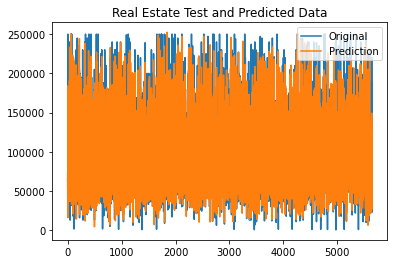

In [77]:
actual_vs_prediction(y_apartments_test_nofac, y_pred_best_apartments_nofac)

## Residuals Distribution 

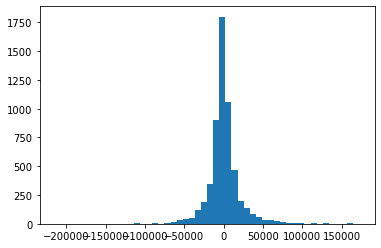

In [78]:
residual_distribution(y_apartments_test_nofac, y_pred_best_apartments_nofac)

# Save Best Models

## Apartments

In [79]:
filename = 'best_model_apartments.sav'
joblib.dump(best_apartments_nofac_new, filename)

['best_model_apartments.sav']

## Houses

In [80]:
filename = 'best_model_houses.sav'
joblib.dump(best_houses_nofac_new, filename)

['best_model_houses.sav']

# Load Models

In [81]:
loaded_model_apartments = joblib.load(os.path.join(os.getcwd(), 'best_model_apartments.sav'))
r2 = loaded_model_apartments.score(X_apartments_test_nofac_new, y_apartments_test_nofac_new)
print(r2)

0.825107516404862


In [82]:
loaded_model_houses = joblib.load(os.path.join(os.getcwd(), 'best_model_houses.sav'))
r2 = loaded_model_houses.score(X_houses_test_nofac_new, y_houses_test_nofac_new)
print(r2)

0.6968167742783218
